In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = "./data/log_{}.txt"

In [3]:
def parse_section(lines: List[str], idx: int, delim="="):
    assert idx < len(lines)
    assert lines[idx].startswith(delim), f"{lines[idx]}"
    animal, idx = [lines[idx]], idx + 1
    while idx < len(lines) and not lines[idx].startswith(delim):
        line = lines[idx]
        if not line.startswith("\n"):
            animal.append(line)
        idx += 1
    return animal, idx

def parse_sections(path, delim="=") -> List[List[str]]:
    animals = []
    with open(path, mode="r") as f:
        lines, idx = f.readlines(), 0
        while idx < len(lines):
            animal, idx = parse_section(lines, idx, delim=delim)
            animals.append(animal)
    return animals

def parse_timestamp(timestamp: str):
    # -- Timestamp: 3400.54
    return float( timestamp[timestamp.find(":") + 1: timestamp.find("\n")] )

def parse_location(location: str):
    x, y = location[location.find("[") + 1 : location.find("]")].split(",")
    return (float(x), float(y))

def parse_temp(temp: str):
    return float( temp[temp.find(":") + 1 : temp.find("\n")] )

def parse_vitals(vitals: str):
    oxygen, hb = vitals.split(",")
    oxygen = float( oxygen[oxygen.find(":") + 1:] )
    hb = float( hb[hb.find(":") + 1: ] )
    return (oxygen, hb)

def parse_type_id(type_id: str):
    space_idx = type_id.find(" ")
    semi_idx = type_id.find(":")
    type_ = type_id[space_idx + 1: semi_idx]
    space_idx = type_id.find(" ", semi_idx)
    id_ = type_id[semi_idx + 1: space_idx]
    return type_, id_

def process_section(section: List[str]):
    timestamp = parse_timestamp(section[0])
    section_labels = [
        ("location", parse_location),
        ("temperature", parse_temp),
        ("oxygen", parse_vitals)
        ]
    res = {"timestamp": timestamp}
    for data in section[1:]:
        for label, processor in section_labels:
            if data.find(label) != -1:
                res[label] = processor(data)
    return res

def process_animal(animal: List[str]):
    type_, id_ = parse_type_id(animal[0])
    timestamp_sections, idx = [], 1
    while idx < len(animal):
        section, idx = parse_section(animal, idx, delim="-")
        timestamp_sections.append(process_section(section))
    return type_, id_, timestamp_sections

def process_animals(animals: List[List[str]]):
    ids_to_type = {}
    ids_data = {}
    for animal in animals:
        type_, id_, sections = process_animal(animal)
        ids_to_type[id_] = type_
        ids_data[id_] = sections
    return ids_to_type, ids_data

def to_df(ids_to_type: Dict[str, str], ids_data: Dict[str, List[Dict[str, Any]]]):
    res = []
    for id_, sections in ids_data.items():
        for section in sections:
            timestamp = section["timestamp"]
            x_gps, y_gps = section["location"]
            temp = section["temperature"]
            oxygen, hr = section["oxygen"]
            res.append( [id_, ids_to_type[id_], timestamp, x_gps, y_gps, temp, oxygen, hr] )
    return pd.DataFrame(res, columns=["Id", "Type", "Timestamp", "X_GPS", "Y_GPS", "Temp", "Oxygen", "Heartbeat"])

def add_speed(df: pd.DataFrame):
    df.insert(3, "Speed", [0 for _ in range(df.shape[0])])
    for id in set(df["Id"]):
        animal: pd.DataFrame = df[df["Id"] == id].sort_values(by=["Timestamp"], ascending=True)
        for i in range(1, animal.shape[0]):
            x1 = animal["X_GPS"].iloc[i-1]
            x2 = animal["X_GPS"].iloc[i]
            y1 = animal["Y_GPS"].iloc[i-1]
            y2 = animal["Y_GPS"].iloc[i]
            t1 = animal["Timestamp"].iloc[i-1]
            t2 = animal["Timestamp"].iloc[i]
            animal["Speed"].iloc[i] = np.sqrt((x2 - x1)**2 + (y2 - y1)**2) / (t2 - t1)
        df.update(animal)
    return df

def parse(data_path: str):
    animals = parse_sections(data_path)
    ids_to_type, ids_data = process_animals(animals)
    return add_speed(to_df(ids_to_type, ids_data))

df = parse(data_path.format(3))


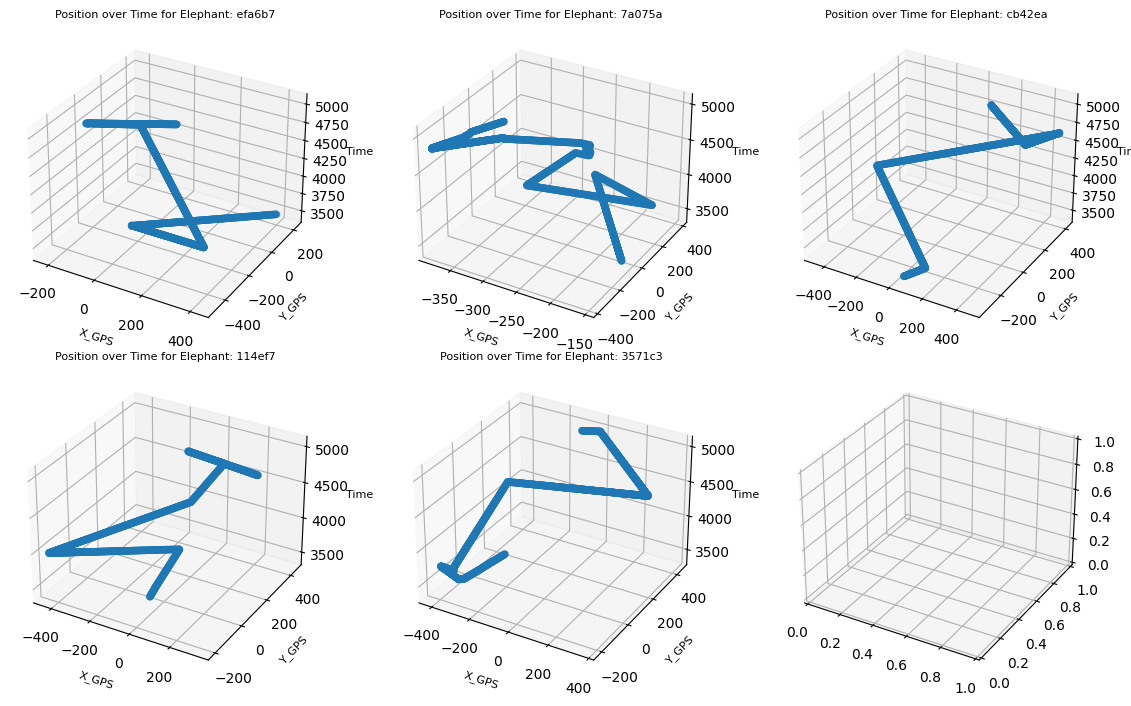

44.593265228906546 45.0
0.9802711565140627 0.98
1.4487182442207847 1.4975453725768062


In [7]:
zebras = df[df["Type"] == "Zebra"].copy()
elephants = df[df["Type"] == "Elephant"].copy()

# def plot_3d(X: np.ndarray, Y: np.ndarray, Z: np.ndarray):
#     fig = plt.figure()
#     ax = fig.add_subplot(projection='3d')
#     ax.scatter(X, Y, Z)
    #fig.show()

chosen_type = "Elephant"
chosen_animal = elephants

fig, axes = plt.subplots(2, 3, figsize=(12, 7), subplot_kw=dict(projection="3d"))
#fig, axes = plt.subplots(2, 3, subplot_kw=dict(projection="3d"))
axes = axes.flatten()
for i, ids in enumerate(set(chosen_animal["Id"])):
    zebs = chosen_animal[chosen_animal["Id"] == ids]
    x = zebs["X_GPS"].to_numpy()
    y = zebs["Y_GPS"].to_numpy()
    z = zebs["Timestamp"].to_numpy()
    speed = zebs["Speed"].to_numpy()
    #print(np.max(speed))
    #sns.kdeplot(data = speed, cumulative = True)
    #sns.kdeplot(data = y, cumulative = True)
    ax = axes[i]
    ax.set_title(f"Position over Time for {chosen_type}: {ids}", fontsize=8)
    ax.set_xlabel("X_GPS", fontsize=8)
    ax.set_ylabel("Y_GPS", fontsize=8)
    ax.set_zlabel("Time", fontsize=8)
    ax.scatter(x, y, z)
    #plot_3d(x, y, z)
    #break
plt.tight_layout()
plt.show()
print(chosen_animal["Heartbeat"].mean(), chosen_animal["Heartbeat"].median())
print(chosen_animal["Oxygen"].mean(), chosen_animal["Oxygen"].median())
print(chosen_animal["Speed"].mean(), chosen_animal["Speed"].median())
#sns.histplot(zebras["Speed"])




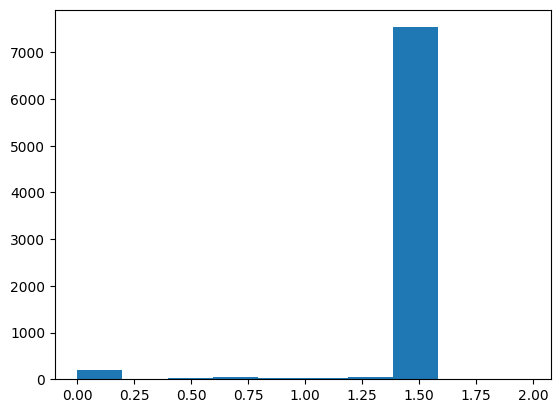

In [13]:
plt.hist(chosen_animal["Speed"])
plt.show()

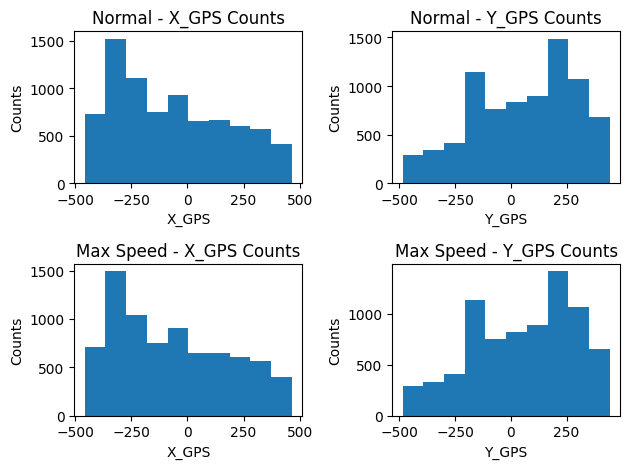

In [14]:
max_speed = chosen_animal[chosen_animal["Speed"] > 0]
fig, axes = plt.subplots(2, 2)
axes[0, 0].hist(chosen_animal["X_GPS"])
axes[0, 0].set_title("Normal - X_GPS Counts")
axes[0, 0].set_xlabel("X_GPS")
axes[0, 0].set_ylabel("Counts")

axes[0, 1].hist(chosen_animal["Y_GPS"])
axes[0, 1].set_title("Normal - Y_GPS Counts")
axes[0, 1].set_xlabel("Y_GPS")
axes[0, 1].set_ylabel("Counts")

axes[1, 0].hist(max_speed["X_GPS"])
axes[1, 0].set_title("Max Speed - X_GPS Counts")
axes[1, 0].set_xlabel("X_GPS")
axes[1, 0].set_ylabel("Counts")

axes[1, 1].hist(max_speed["Y_GPS"])
axes[1, 1].set_title("Max Speed - Y_GPS Counts")
axes[1, 1].set_xlabel("Y_GPS")
axes[1, 1].set_ylabel("Counts")

plt.tight_layout()
plt.show()

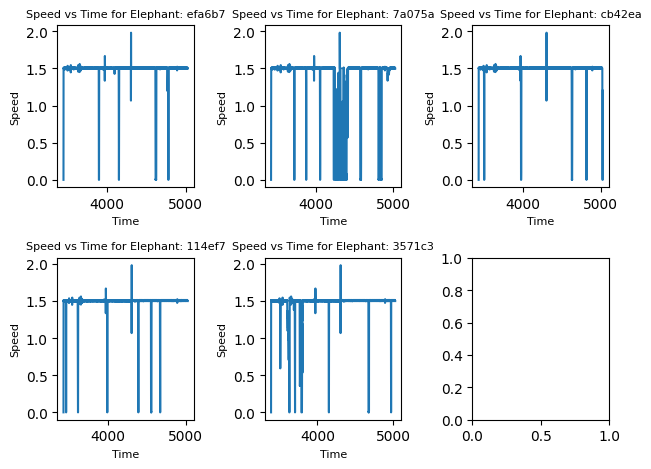

In [10]:
fig, axes = plt.subplots(2, 3)#, figsize=(15, 7))
axes = axes.flatten()
for i, ids in enumerate(set(chosen_animal["Id"])):
    zebs = chosen_animal[chosen_animal["Id"] == ids]
    timestamp = zebs["Timestamp"].to_numpy()
    speed = zebs["Speed"].to_numpy()
    #print(np.max(speed))
    #sns.kdeplot(data = speed, cumulative = True)
    #sns.kdeplot(data = y, cumulative = True)
    ax = axes[i]
    ax.set_title(f"Speed vs Time for {chosen_type}: {ids}", fontsize = 8)
    ax.set_xlabel("Time", fontsize = 8)
    ax.set_ylabel("Speed", fontsize = 8)
    ax.plot(timestamp, speed)
plt.tight_layout()
plt.show()

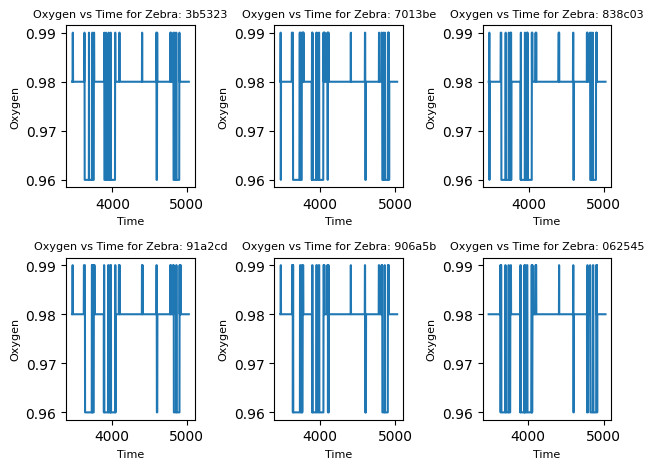

In [100]:
fig, axes = plt.subplots(2, 3)#, figsize=(15, 7))
axes = axes.flatten()
for i, ids in enumerate(set(chosen_animal["Id"])):
    zebs = chosen_animal[chosen_animal["Id"] == ids]
    timestamp = zebs["Timestamp"].to_numpy()
    speed = zebs["Oxygen"].to_numpy()
    #print(np.max(speed))
    #sns.kdeplot(data = speed, cumulative = True)
    #sns.kdeplot(data = y, cumulative = True)
    ax = axes[i]
    ax.set_title(f"Oxygen vs Time for Zebra: {ids}", fontsize = 8)
    ax.set_xlabel("Time", fontsize = 8)
    ax.set_ylabel("Oxygen", fontsize = 8)
    ax.plot(timestamp, speed)
plt.tight_layout()
plt.show()

<AxesSubplot: xlabel='Speed', ylabel='Density'>

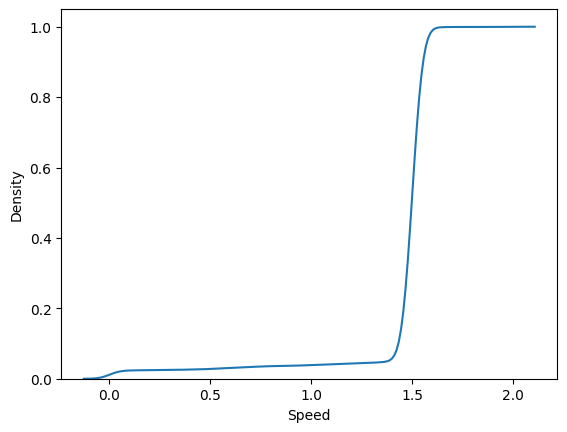

In [11]:
sns.kdeplot(data = chosen_animal["Speed"], cumulative = True)